<a href="https://colab.research.google.com/github/nicolasbose/ReNOMO/blob/main/metsunami_imbituba.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:
df = pd.read_csv('/content/imbi_718_2001_2022.csv', sep=';')

In [9]:
df

,dd/mm/aaaa,hh:00,obser,previ,nm168
0,01/12/2001,02:00,2.045,1.817,0
1,01/12/2001,03:00,2.017,1.796,0
2,01/12/2001,04:00,1.947,1.727,0
3,01/12/2001,05:00,1.849,1.632,0
4,01/12/2001,06:00,1.735,1.523,0
...,...,...,...,...,...
184817,31/12/2022,19:00,1.669,1.689,1.523
184818,31/12/2022,20:00,1.609,1.674,1.523
184819,31/12/2022,21:00,1.610,1.641,1.523
184820,31/12/2022,22:00,1.572,1.623,1.524


In [10]:
# Concatenate date and time columns
#df['tempo'] = df['dd/mm/aaaa '] + ' ' + df['hh:00 ']
datetime_range = pd.date_range(start='2001-12-01 02:00', end='2022-12-31 23:00', freq='H')
## Convert 'tempo' column to datetime format
df['tempo'] = pd.to_datetime(datetime_range)

df.index = df['tempo']

In [11]:
# Replace black space with NaN
df['obser '] = df['obser '].replace(r'^\s*$', np.nan, regex=True)
# Transforme object to float
df['obser '] = df['obser '].astype(float)

In [12]:
## Remove unreal values from the time series
df1 = df[df['obser '] <= 100]

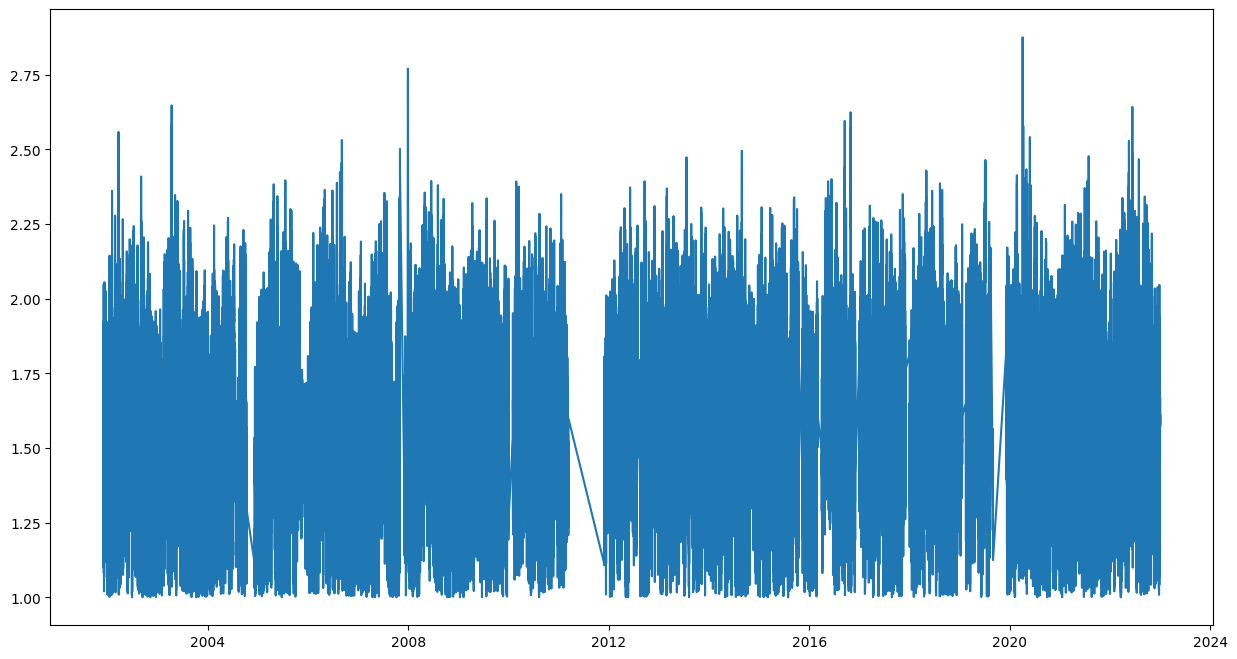

In [13]:
fig, ax = plt.subplots(figsize=[15,8])

ax.plot(df1.index,df1['obser '])

<Axes: xlabel='tempo'>

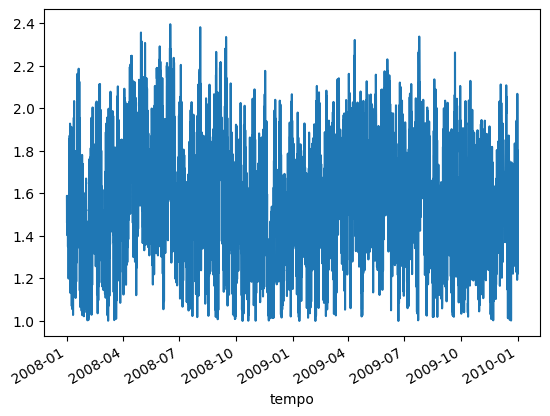

In [14]:
#Separando os tempos

df_sliced = df1.loc['2008':'2009']
df_sliced['obser '].plot()

In [15]:
## DROP
df_sliced.drop(['nm168      ', 'dd/mm/aaaa ', 'hh:00 '], axis=1, inplace=True)

<ipython-input-15-24bf28e08bec>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sliced.drop(['nm168      ', 'dd/mm/aaaa ', 'hh:00 '], axis=1, inplace=True)


<ipython-input-16-adab0a309263>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sliced['obser_l1_nearest'] = df_sliced['obser '].interpolate(method='nearest')


<Axes: xlabel='data', ylabel='AVg Water Level [cm]'>

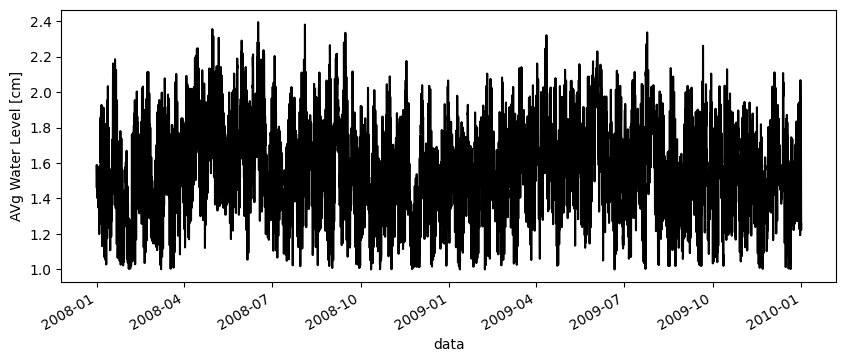

In [16]:
# Preenchimento usando interpolação baseada em vizinhos mais próximos
df_sliced['obser_l1_nearest'] = df_sliced['obser '].interpolate(method='nearest')

# Preenchimento usando interpolação cúbica
#df['avg_water_l1_cubic'] = df['avg_water_l1'].interpolate(method='cubic')
df_sliced.obser_l1_nearest.plot(color='k',xlabel='data',ylabel='AVg Water Level [cm]',figsize=(10,4))

In [30]:
from statsmodels.tsa.stattools import adfuller


def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [31]:

adf_test(filtered_tide_data)

Results of Dickey-Fuller Test:
Test Statistic                -5.790413e+00
p-value                        4.887209e-07
#Lags Used                     4.400000e+01
Number of Observations Used    1.724200e+04
Critical Value (1%)           -3.430729e+00
Critical Value (5%)           -2.861708e+00
Critical Value (10%)          -2.566859e+00
dtype: float64


In [28]:
from statsmodels.tsa.stattools import kpss


def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [ ]:
from scipy.signal import lfilter

In [29]:
kpss_test(filtered_tide_data)

Results of KPSS Test:
Test Statistic            0.604857
p-value                   0.022195
Lags Used                77.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


In [ ]:
# Define the Lanczos filter coefficients
window_size = 48
s = window_size * 2 + 1
coefficients = np.sinc(2 * time / s)

# Apply the Lanczos filter
smoothed_data = lfilter(coefficients, 1.0, data)

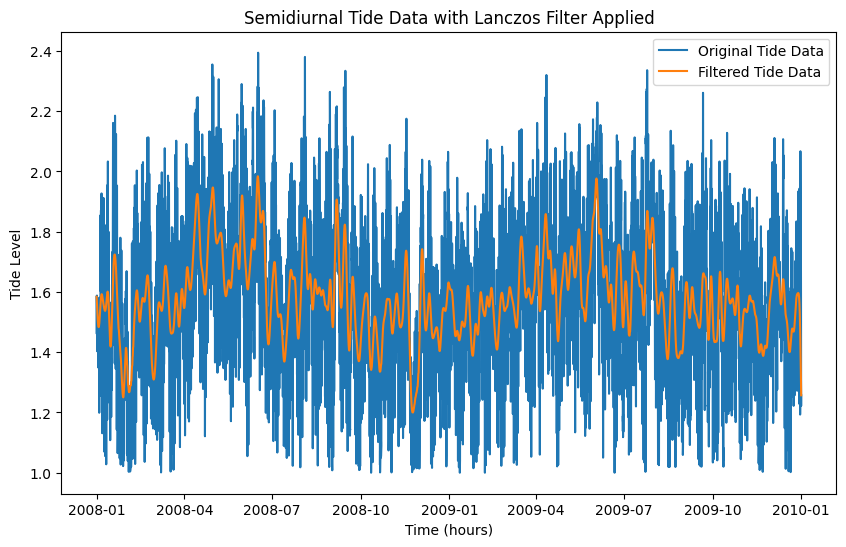

In [27]:
import numpy as np
from scipy.signal import firwin, filtfilt
import matplotlib.pyplot as plt

# Assuming tide_data contains your tide data

# Sampling frequency (assuming data is sampled hourly)
fs = 1.0 / 3600.0  # 1 sample per hour

# Define cutoff frequency and filter length
cutoff_freq = 0.00000222  # approximately 0.08 cycles per hour
filter_length = 101  # Adjust as needed

# Design a low-pass FIR filter (Lanczos filter)
taps = firwin(filter_length, cutoff_freq, window='lanczos')

# Apply the filter to the tide data
filtered_tide_data = filtfilt(taps, 1.0, df_sliced.obser_l1_nearest)

# Plot the original and filtered tide data
plt.figure(figsize=(10, 6))
plt.plot(df_sliced.obser_l1_nearest, label='Original Tide Data')
plt.plot(df_sliced.index, filtered_tide_data, label='Filtered Tide Data')
plt.xlabel('Time (hours)')
plt.ylabel('Tide Level')
plt.legend()
plt.title('Semidiurnal Tide Data with Lanczos Filter Applied')
plt.show()


In [25]:
filtered_tide_data.shape

(17287,)